In [1]:
import torchvision
from torchvision import transforms
import numpy as np
import torch
import json
from torch.utils.data import DataLoader
import os
import matplotlib.pyplot as plt
from torchvision.utils import save_image

In [2]:
# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [3]:
# Load the pretrained model
pretrained_model = torchvision.models.resnet34(weights='IMAGENET1K_V1')
pretrained_model = pretrained_model.to(device)
pretrained_model.eval()

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 225MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [4]:
# Define normalization parameters
mean_norms = np.array([0.485, 0.456, 0.406], dtype=np.float32)
std_norms = np.array([0.229, 0.224, 0.225], dtype=np.float32)

In [5]:
# Set up transforms
plain_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_norms, std=std_norms)
])


In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
# Load dataset
# dataset_path = "./TestDataSet"
dataset_path = "/content/drive/My Drive/TestDataSet"
dataset = torchvision.datasets.ImageFolder(root=dataset_path, transform=plain_transforms)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)


In [11]:
# Load label mapping
with open('/content/drive/My Drive/TestDataSet/labels_list.json', 'r') as f:
    label_list = json.load(f)

In [12]:
# Build mapping from ImageFolder class idx to ImageNet idx
folder_to_idx = dataset.class_to_idx
imagenet_indices = [int(label.split(':')[0]) for label in label_list]
idx_to_imagenet = {v: imagenet_indices[i] for i, (k, v) in enumerate(sorted(folder_to_idx.items()))}

In [13]:
# Evaluation function
def evaluate_model(model, data_loader, mapping_dict=None):
    """Evaluate model performance."""
    model.eval()
    top1_correct = 0
    top5_correct = 0
    total = 0

    with torch.no_grad():
        for images, targets in data_loader:
            images = images.to(device)
            targets_np = targets.cpu().numpy()
            outputs = model(images)

            # Get top-5 predictions
            _, pred_top5 = outputs.topk(5, dim=1)
            pred_top5 = pred_top5.cpu().numpy()

            # Map ground truth if mapping provided
            if mapping_dict:
                gt_imagenet = [mapping_dict[t] for t in targets_np]
            else:
                gt_imagenet = targets_np

            # Top-1 accuracy
            top1_preds = pred_top5[:, 0]
            top1_correct += sum([p == gt for p, gt in zip(top1_preds, gt_imagenet)])

            # Top-5 accuracy
            for i, gt in enumerate(gt_imagenet):
                if gt in pred_top5[i]:
                    top5_correct += 1

            total += len(targets)

    return top1_correct / total, top5_correct / total


In [14]:
# Evaluate original accuracy
print("\n=== Task 1: Evaluating Original Model ===")
top1_acc, top5_acc = evaluate_model(pretrained_model, dataloader, idx_to_imagenet)
print(f"Original Top-1 Accuracy: {top1_acc:.4f}")
print(f"Original Top-5 Accuracy: {top5_acc:.4f}")


=== Task 1: Evaluating Original Model ===
Original Top-1 Accuracy: 0.7600
Original Top-5 Accuracy: 0.9420


In [15]:
# Utility functions
def denormalize(tensor, mean, std):
    """Convert normalized tensor back to [0,1] range."""
    tensor = tensor.clone()
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return torch.clamp(tensor, 0, 1)

def compute_linf_distance(original, perturbed):
    """Compute L∞ distance between original and perturbed images."""
    # Denormalize both to [0,1] space for fair comparison
    original_denorm = denormalize(original.clone().cpu(), mean_norms, std_norms)
    perturbed_denorm = denormalize(perturbed.clone().cpu(), mean_norms, std_norms)

    # Compute maximum absolute difference
    linf_dist = (original_denorm - perturbed_denorm).abs().max().item()
    return linf_dist

In [16]:
# Task 2: Implement FGSM exactly as described in the assignment
def fgsm_attack(model, image, target, epsilon=0.019):
    """
    A simpler FGSM implementation that avoids view issues and ensures
    exactly epsilon L∞ distance.
    """
    # Ensure correct data type
    image = image.clone().detach().to(device).float()
    image.requires_grad = True

    # Forward pass
    output = model(image)
    target_tensor = torch.tensor([target], dtype=torch.long).to(device)
    loss = torch.nn.functional.cross_entropy(output, target_tensor)

    # Backward pass
    model.zero_grad()
    loss.backward()

    # Get gradient sign
    data_grad = image.grad.data
    sign_data_grad = data_grad.sign()

    # Create perturbation
    # This approach works in normalized space
    # For an L∞ distance of epsilon in [0,1] image space,
    # we need to multiply by epsilon/std for each channel
    perturbation = torch.zeros_like(image)
    for c in range(3):
        # Scale epsilon by 1/std for each channel
        perturbation[:, c:c+1] = sign_data_grad[:, c:c+1] * (epsilon / std_norms[c])

    # Apply perturbation
    perturbed_image = image + perturbation

    # Ensure valid range for the model
    mean_tensor = torch.tensor(mean_norms, dtype=torch.float32, device=device).view(1, 3, 1, 1)
    std_tensor = torch.tensor(std_norms, dtype=torch.float32, device=device).view(1, 3, 1, 1)
    mins = (torch.tensor(0.0, dtype=torch.float32, device=device) - mean_tensor) / std_tensor
    maxs = (torch.tensor(1.0, dtype=torch.float32, device=device) - mean_tensor) / std_tensor
    perturbed_image = torch.clamp(perturbed_image, mins, maxs)

    return perturbed_image.detach()

In [17]:
# Create directory for adversarial examples
adv_dir = '/content/drive/My Drive/AdversarialTestSet1'
os.makedirs(adv_dir, exist_ok=True)

# Ensure class subfolders exist
for class_name in dataset.classes:
    os.makedirs(os.path.join(adv_dir, class_name), exist_ok=True)

In [44]:
# Attack parameters
epsilon = 0.01  # As specified in the assignment
successful_examples = []  # Store successful attack examples for visualization

In [45]:
# Process each image
print("\n=== Task 2: Creating Adversarial Examples with FGSM ===")
for i, (img, target) in enumerate(dataset):
    # Original image (add batch dimension)
    img_batch = img.unsqueeze(0).to(device).float()

    # Use the true label for the attack (not the model's prediction)
    true_imagenet_label = idx_to_imagenet[target]
    perturbed_img = fgsm_attack(pretrained_model, img_batch, true_imagenet_label, epsilon)

    # Get adversarial prediction
    with torch.no_grad():
        adv_output = pretrained_model(perturbed_img)
        _, adv_pred = torch.max(adv_output, 1)
        adv_pred_imagenet = adv_pred.item()

    # Check if attack succeeded
    attack_succeeded = (adv_pred_imagenet != true_imagenet_label)

    # Verify L∞ distance constraint
    linf_dist = compute_linf_distance(img_batch, perturbed_img)

    # Store successful examples for visualization (if needed)
    if attack_succeeded and len(successful_examples) < 5:
        orig_img_denorm = denormalize(img.clone(), mean_norms, std_norms)
        pert_img_denorm = denormalize(perturbed_img.squeeze(0).cpu(), mean_norms, std_norms)

        # Get class names
        orig_label_name = next((label.split(':', 1)[1].strip()
                          for label in label_list
                          if label.startswith(f"{true_imagenet_label}:")), "Unknown")

        adv_label_name = next((label.split(':', 1)[1].strip()
                          for label in label_list
                          if label.startswith(f"{adv_pred_imagenet}:")), "Unknown")

        # Store for visualization
        successful_examples.append((
            orig_label_name,
            orig_img_denorm,
            pert_img_denorm,
            adv_label_name,
            linf_dist
        ))

    # Save perturbed image
    perturbed_img_denorm = denormalize(perturbed_img.squeeze(0).cpu(), mean_norms, std_norms)

    # Get save path based on original path
    orig_path, _ = dataset.samples[i]
    class_folder = orig_path.split(os.sep)[-2]
    img_name = os.path.basename(orig_path)
    save_path = os.path.join(adv_dir, class_folder, img_name)

    # Save the image
    save_image(perturbed_img_denorm, save_path)

    if i % 50 == 0:
        print(f"Processed {i+1}/{len(dataset)} images. L∞ distance: {linf_dist:.6f}")

print(f"All adversarial images saved to {adv_dir}")



=== Task 2: Creating Adversarial Examples with FGSM ===
Processed 1/500 images. L∞ distance: 0.010223
Processed 51/500 images. L∞ distance: 0.010223
Processed 101/500 images. L∞ distance: 0.010223
Processed 151/500 images. L∞ distance: 0.010223
Processed 201/500 images. L∞ distance: 0.010223
Processed 251/500 images. L∞ distance: 0.010223
Processed 301/500 images. L∞ distance: 0.010223
Processed 351/500 images. L∞ distance: 0.010223
Processed 401/500 images. L∞ distance: 0.010223
Processed 451/500 images. L∞ distance: 0.010223
All adversarial images saved to /content/drive/My Drive/AdversarialTestSet1


Visualization saved to fgsm_examples.png


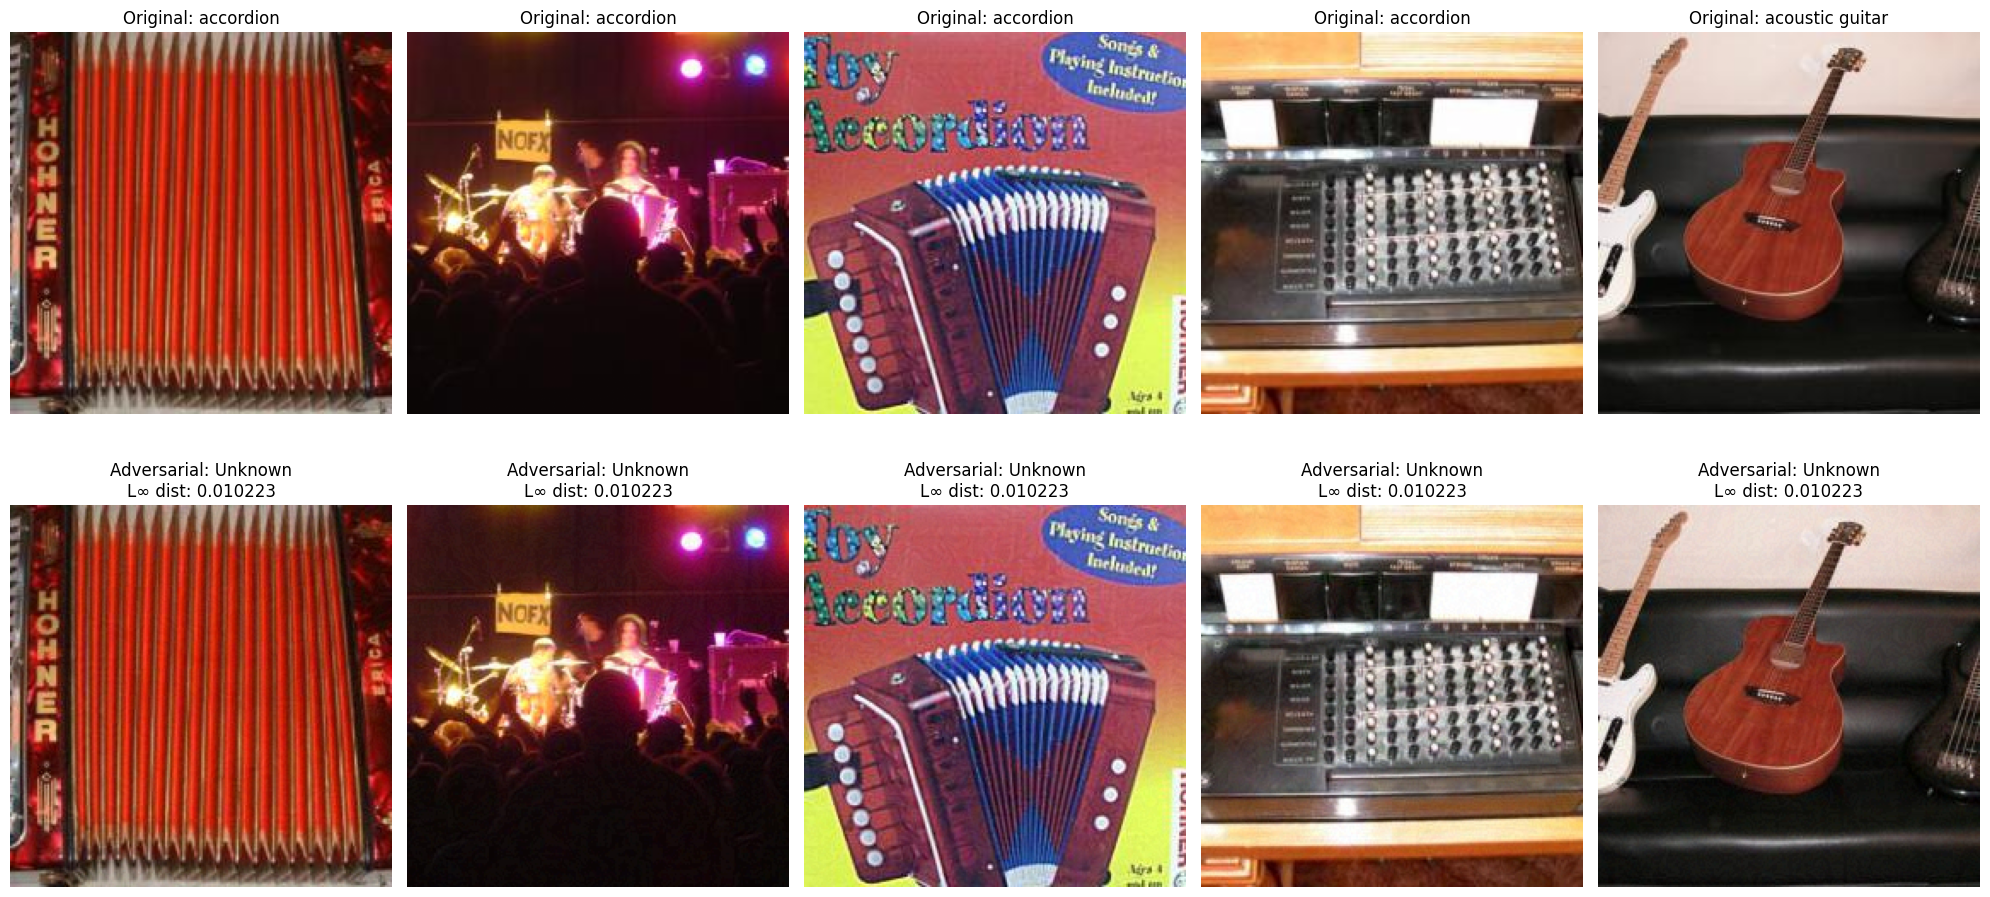

In [46]:

# Visualize successful examples
if successful_examples:
    plt.figure(figsize=(20, 10))

    for i, (orig_label, orig_img, adv_img, adv_label, linf_dist) in enumerate(successful_examples):
        # Original
        plt.subplot(2, len(successful_examples), i+1)
        plt.imshow(orig_img.permute(1, 2, 0).numpy())
        plt.title(f"Original: {orig_label}")
        plt.axis('off')

        # Adversarial
        plt.subplot(2, len(successful_examples), i+len(successful_examples)+1)
        plt.imshow(adv_img.permute(1, 2, 0).numpy())
        plt.title(f"Adversarial: {adv_label}\nL∞ dist: {linf_dist:.6f}")
        plt.axis('off')

    plt.tight_layout()
    plt.savefig('fgsm_examples.png')
    print("Visualization saved to fgsm_examples.png")
else:
    print("No successful attack examples found for visualization.")

In [47]:
# Load adversarial dataset for evaluation
adv_dataset = torchvision.datasets.ImageFolder(root=adv_dir, transform=plain_transforms)
adv_loader = DataLoader(adv_dataset, batch_size=32, shuffle=False)

# Build mapping for adversarial dataset
adv_folder_to_idx = adv_dataset.class_to_idx
adv_idx_to_imagenet = {v: imagenet_indices[i] for i, (k, v) in enumerate(sorted(adv_folder_to_idx.items()))}

# Evaluate on adversarial dataset
print("\n=== Evaluating on Adversarial Test Set 1 ===")
adv_top1_acc, adv_top5_acc = evaluate_model(pretrained_model, adv_loader, adv_idx_to_imagenet)
print(f"Adversarial Top-1 Accuracy: {adv_top1_acc:.4f}")
print(f"Adversarial Top-5 Accuracy: {adv_top5_acc:.4f}")

# Calculate accuracy drop
top1_drop = (top1_acc - adv_top1_acc) / top1_acc * 100
top5_drop = (top5_acc - adv_top5_acc) / top5_acc * 100
print(f"\nAccuracy Drop:")
print(f"  Top-1 Accuracy Drop: {top1_drop:.2f}%")
print(f"  Top-5 Accuracy Drop: {top5_drop:.2f}%")


=== Evaluating on Adversarial Test Set 1 ===
Adversarial Top-1 Accuracy: 0.1300
Adversarial Top-5 Accuracy: 0.4780

Accuracy Drop:
  Top-1 Accuracy Drop: 82.89%
  Top-5 Accuracy Drop: 49.26%


In [48]:
# Task 3: Improved attacks - Momentum Iterative FGSM
def momentum_iterative_fgsm(model, image, target, epsilon=0.01, steps=10, alpha=0.004, decay=0.9):
    """
    Momentum Iterative Fast Gradient Sign Method.

    Args:
        model: The model to attack
        image: Input image
        target: True label
        epsilon: Maximum perturbation (L∞ norm)
        steps: Number of attack iterations
        alpha: Step size for each iteration (should be epsilon/steps * factor)
        decay: Momentum decay factor

    Returns:
        perturbed_image: Adversarial example
    """
    # Initialize
    image = image.clone().detach().to(device).float()
    perturbed_image = image.clone()
    momentum_grad = torch.zeros_like(image).to(device)

    # Calculate bounds for valid normalized images
    mean_tensor = torch.tensor(mean_norms, dtype=torch.float32, device=device).view(1, 3, 1, 1)
    std_tensor = torch.tensor(std_norms, dtype=torch.float32, device=device).view(1, 3, 1, 1)
    mins = (torch.tensor(0.0, dtype=torch.float32, device=device) - mean_tensor) / std_tensor
    maxs = (torch.tensor(1.0, dtype=torch.float32, device=device) - mean_tensor) / std_tensor

    # Calculate channel-specific epsilon values for proper L∞ constraint
    epsilon_tensor = torch.tensor([epsilon / s for s in std_norms],
                                 dtype=torch.float32, device=device).view(1, 3, 1, 1)
    alpha_tensor = torch.tensor([alpha / s for s in std_norms],
                               dtype=torch.float32, device=device).view(1, 3, 1, 1)

    # Iteratively apply the attack
    for i in range(steps):
        # Enable gradients
        perturbed_image.requires_grad = True

        # Forward pass
        output = model(perturbed_image)
        target_tensor = torch.tensor([target], dtype=torch.long).to(device)

        # Cross-entropy loss - for untargeted attack, we want to maximize this
        loss = torch.nn.functional.cross_entropy(output, target_tensor)

        # Backward pass
        model.zero_grad()
        loss.backward()

        # Get gradients and update momentum
        grad = perturbed_image.grad.data
        momentum_grad = decay * momentum_grad + grad / grad.norm(1)

        # Update image with momentum-enhanced gradient
        with torch.no_grad():
            grad_sign = momentum_grad.sign()
            perturbed_image = perturbed_image + alpha_tensor * grad_sign

            # Project back to epsilon-ball around original image
            delta = perturbed_image - image
            # Project channel-wise to maintain proper L∞ distance
            for c in range(3):
                delta[:, c:c+1] = torch.clamp(delta[:, c:c+1],
                                             -epsilon_tensor[:, c:c+1],
                                             epsilon_tensor[:, c:c+1])

            perturbed_image = image + delta

            # Ensure the result is within valid range
            perturbed_image = torch.clamp(perturbed_image, mins, maxs)

    return perturbed_image.detach()


In [49]:
# Create directory for improved adversarial examples
adv_dir2 = 'AdversarialTestSet2'
os.makedirs(adv_dir2, exist_ok=True)

# Ensure class subfolders exist
for class_name in dataset.classes:
    os.makedirs(os.path.join(adv_dir2, class_name), exist_ok=True)

# Improved attack parameters
epsilon = 0.01  # Same as Task 2
steps = 10      # Number of iterations
alpha = 0.004   # Step size (0.2 * epsilon / steps) - using smaller steps for better convergence
decay = 0.9     # Momentum decay factor
successful_examples = []  # Store successful examples for visualization


In [50]:
# Process each image
print("\n=== Task 3: Creating Improved Adversarial Examples with MI-FGSM ===")
for i, (img, target) in enumerate(dataset):
    # Original image (add batch dimension)
    img_batch = img.unsqueeze(0).to(device).float()

    # Get true label
    true_imagenet_label = idx_to_imagenet[target]

    # Apply momentum iterative FGSM attack
    perturbed_img = momentum_iterative_fgsm(
        pretrained_model, img_batch, true_imagenet_label,
        epsilon, steps, alpha, decay
    )

    # Get adversarial prediction
    with torch.no_grad():
        adv_output = pretrained_model(perturbed_img)
        _, adv_pred = torch.max(adv_output, 1)
        adv_pred_imagenet = adv_pred.item()

    # Check if attack succeeded
    attack_succeeded = (adv_pred_imagenet != true_imagenet_label)

    # Verify L∞ distance constraint
    linf_dist = compute_linf_distance(img_batch, perturbed_img)

    # Store successful examples for visualization
    if attack_succeeded and len(successful_examples) < 5:
        orig_img_denorm = denormalize(img.clone(), mean_norms, std_norms)
        pert_img_denorm = denormalize(perturbed_img.squeeze(0).cpu(), mean_norms, std_norms)

        # Get class names
        orig_label_name = next((label.split(':', 1)[1].strip()
                          for label in label_list
                          if label.startswith(f"{true_imagenet_label}:")), "Unknown")

        adv_label_name = next((label.split(':', 1)[1].strip()
                          for label in label_list
                          if label.startswith(f"{adv_pred_imagenet}:")), "Unknown")

        # Store for visualization
        successful_examples.append((
            orig_label_name,
            orig_img_denorm,
            pert_img_denorm,
            adv_label_name,
            linf_dist
        ))

    # Save perturbed image
    perturbed_img_denorm = denormalize(perturbed_img.squeeze(0).cpu(), mean_norms, std_norms)

    # Get save path based on original path
    orig_path, _ = dataset.samples[i]
    class_folder = orig_path.split(os.sep)[-2]
    img_name = os.path.basename(orig_path)
    save_path = os.path.join(adv_dir2, class_folder, img_name)

    # Save the image
    save_image(perturbed_img_denorm, save_path)

    if i % 50 == 0:
        print(f"Processed {i+1}/{len(dataset)} images. L∞ distance: {linf_dist:.6f}")

print(f"All improved adversarial images saved to {adv_dir2}")



=== Task 3: Creating Improved Adversarial Examples with MI-FGSM ===
Processed 1/500 images. L∞ distance: 0.010223
Processed 51/500 images. L∞ distance: 0.010223
Processed 101/500 images. L∞ distance: 0.010223
Processed 151/500 images. L∞ distance: 0.010223
Processed 201/500 images. L∞ distance: 0.010223
Processed 251/500 images. L∞ distance: 0.010223
Processed 301/500 images. L∞ distance: 0.010223
Processed 351/500 images. L∞ distance: 0.010223
Processed 401/500 images. L∞ distance: 0.010223
Processed 451/500 images. L∞ distance: 0.010223
All improved adversarial images saved to AdversarialTestSet2


Visualization saved to mifgsm_examples.png


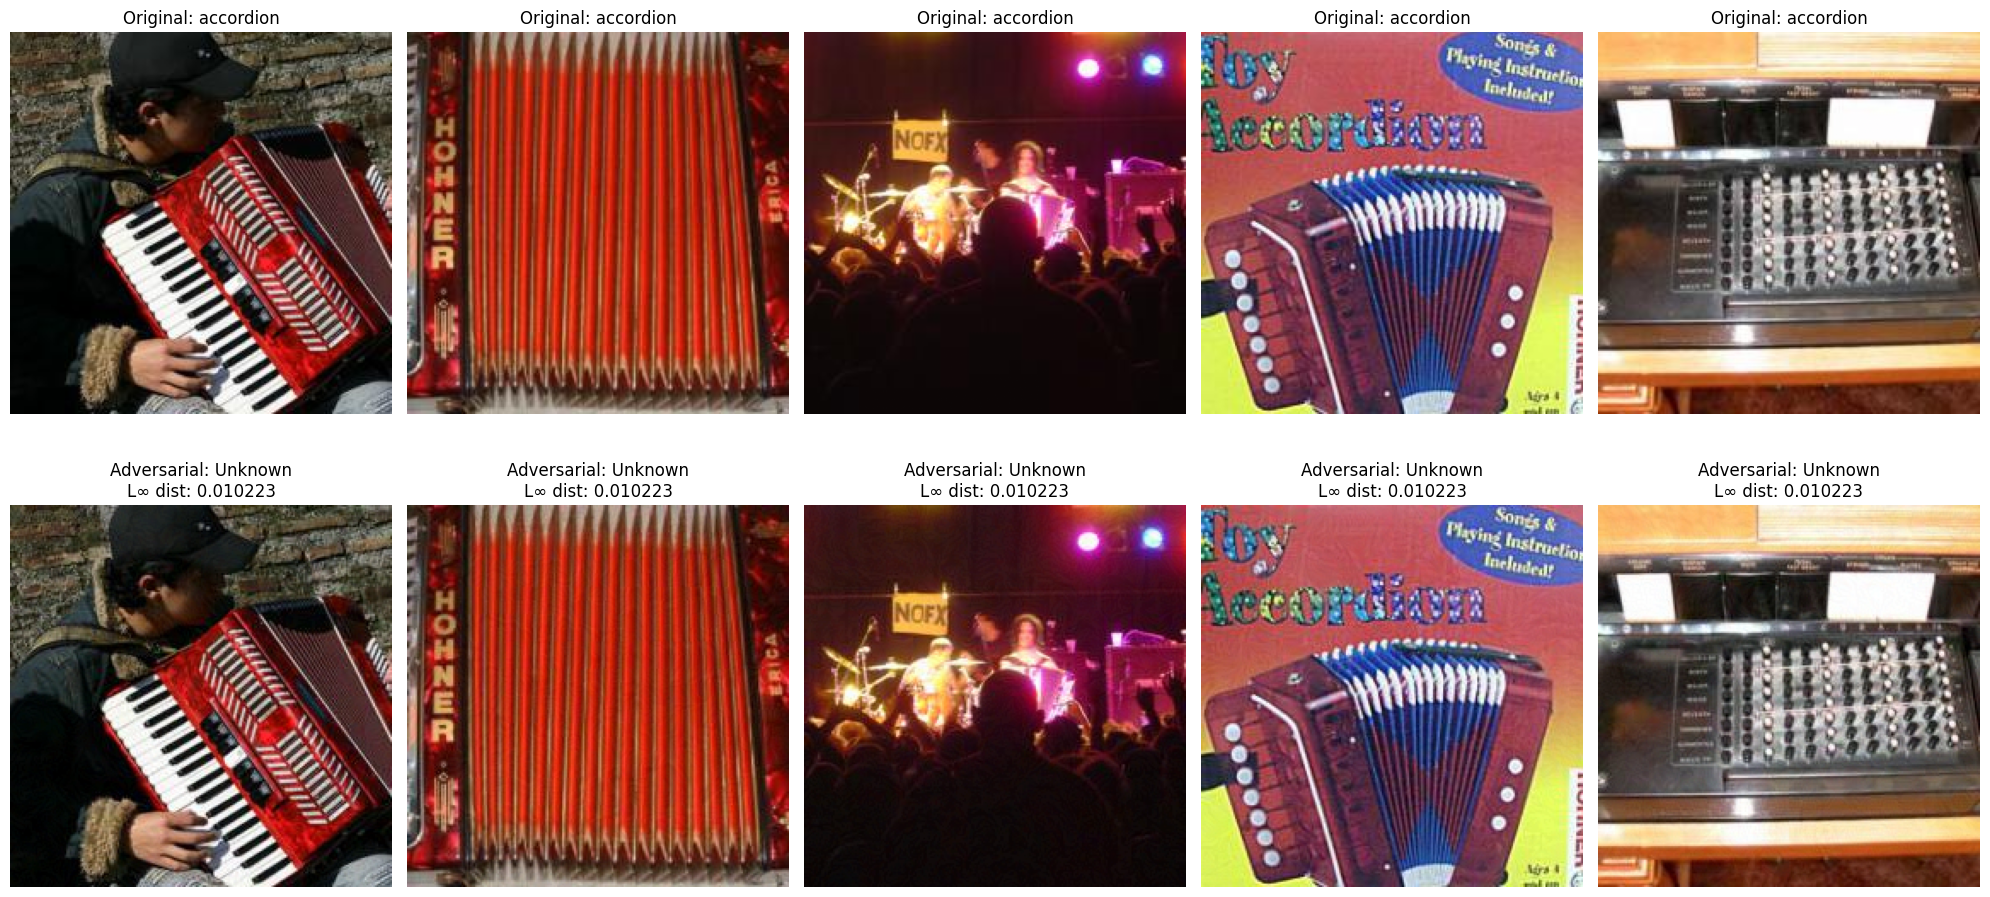

In [51]:

# Visualize successful examples
if successful_examples:
    plt.figure(figsize=(20, 10))

    for i, (orig_label, orig_img, adv_img, adv_label, linf_dist) in enumerate(successful_examples):
        # Original
        plt.subplot(2, len(successful_examples), i+1)
        plt.imshow(orig_img.permute(1, 2, 0).numpy())
        plt.title(f"Original: {orig_label}")
        plt.axis('off')

        # Adversarial
        plt.subplot(2, len(successful_examples), i+len(successful_examples)+1)
        plt.imshow(adv_img.permute(1, 2, 0).numpy())
        plt.title(f"Adversarial: {adv_label}\nL∞ dist: {linf_dist:.6f}")
        plt.axis('off')

    plt.tight_layout()
    plt.savefig('mifgsm_examples.png')
    print("Visualization saved to mifgsm_examples.png")
else:
    print("No successful attack examples found for visualization.")

In [52]:

# Load improved adversarial dataset for evaluation
adv_dataset2 = torchvision.datasets.ImageFolder(root=adv_dir2, transform=plain_transforms)
adv_loader2 = DataLoader(adv_dataset2, batch_size=32, shuffle=False)

# Build mapping for improved adversarial dataset
adv_folder_to_idx2 = adv_dataset2.class_to_idx
adv_idx_to_imagenet2 = {v: imagenet_indices[i] for i, (k, v) in enumerate(sorted(adv_folder_to_idx2.items()))}

# Evaluate on improved adversarial dataset
print("\n=== Evaluating on Adversarial Test Set 2 (MI-FGSM) ===")
adv_top1_acc2, adv_top5_acc2 = evaluate_model(pretrained_model, adv_loader2, adv_idx_to_imagenet2)
print(f"MI-FGSM Adversarial Top-1 Accuracy: {adv_top1_acc2:.4f}")
print(f"MI-FGSM Adversarial Top-5 Accuracy: {adv_top5_acc2:.4f}")

# Calculate accuracy drop
top1_drop2 = (top1_acc - adv_top1_acc2) / top1_acc * 100
top5_drop2 = (top5_acc - adv_top5_acc2) / top5_acc * 100
print(f"\nAccuracy Drop with MI-FGSM:")
print(f"  Top-1 Accuracy Drop: {top1_drop2:.2f}%")
print(f"  Top-5 Accuracy Drop: {top5_drop2:.2f}%")

# Compare with FGSM (Task 2) results
print("\n=== Comparison of Attack Methods ===")
print(f"Original Top-1 Accuracy: {top1_acc:.4f}")
print(f"FGSM (Task 2) Top-1 Accuracy: {adv_top1_acc:.4f} (Drop: {top1_drop:.2f}%)")
print(f"MI-FGSM (Task 3) Top-1 Accuracy: {adv_top1_acc2:.4f} (Drop: {top1_drop2:.2f}%)")
print(f"Task 3 improvement over Task 2: {top1_drop2 - top1_drop:.2f}%")


=== Evaluating on Adversarial Test Set 2 (MI-FGSM) ===
MI-FGSM Adversarial Top-1 Accuracy: 0.0460
MI-FGSM Adversarial Top-5 Accuracy: 0.4820

Accuracy Drop with MI-FGSM:
  Top-1 Accuracy Drop: 93.95%
  Top-5 Accuracy Drop: 48.83%

=== Comparison of Attack Methods ===
Original Top-1 Accuracy: 0.7600
FGSM (Task 2) Top-1 Accuracy: 0.1300 (Drop: 82.89%)
MI-FGSM (Task 3) Top-1 Accuracy: 0.0460 (Drop: 93.95%)
Task 3 improvement over Task 2: 11.05%


In [53]:
def patch_attack(model, image, target, epsilon=0.4, steps=20, alpha=0.03, decay=0.9, patch_size=64):
    """
    MI-FGSM attack applied only to a 32x32 patch.
    """
    image = image.clone().detach().to(device).float()
    perturbed = image.clone()
    momentum = torch.zeros_like(image).to(device)

    _, _, H, W = image.shape
    y = np.random.randint(0, H - patch_size)
    x = np.random.randint(0, W - patch_size)

    mean_tensor = torch.tensor(mean_norms, dtype=torch.float32, device=device).view(1, 3, 1, 1)
    std_tensor = torch.tensor(std_norms, dtype=torch.float32, device=device).view(1, 3, 1, 1)
    mins = (torch.tensor(0.0, dtype=torch.float32, device=device) - mean_tensor) / std_tensor
    maxs = (torch.tensor(1.0, dtype=torch.float32, device=device) - mean_tensor) / std_tensor

    epsilon_tensor = torch.tensor([epsilon / s for s in std_norms], device=device).view(1, 3, 1, 1)
    alpha_tensor = torch.tensor([alpha / s for s in std_norms], device=device).view(1, 3, 1, 1)

    for _ in range(steps):
        perturbed.requires_grad = True
        output = model(perturbed)
        loss = torch.nn.functional.cross_entropy(output, torch.tensor([target], dtype=torch.long, device=device))
        model.zero_grad()
        loss.backward()

        grad = perturbed.grad.data
        grad_patch = grad[:, :, y:y+patch_size, x:x+patch_size]
        momentum_patch = momentum[:, :, y:y+patch_size, x:x+patch_size]

        momentum_patch = decay * momentum_patch + grad_patch / grad_patch.norm(1)
        update = alpha_tensor[:, :, :patch_size, :patch_size] * momentum_patch.sign()

        with torch.no_grad():
            perturbed[:, :, y:y+patch_size, x:x+patch_size] += update

            delta = perturbed - image
            for c in range(3):
                delta[:, c:c+1] = torch.clamp(
                    delta[:, c:c+1],
                    -epsilon_tensor[:, c:c+1],
                    epsilon_tensor[:, c:c+1]
                )

            perturbed = image + delta
            perturbed = torch.clamp(perturbed, mins, maxs)

    return perturbed.detach()


In [54]:
# === TASK 4 ===

# Set new parameters for patch attack
patch_adv_dir = 'AdversarialTestSet3'
os.makedirs(patch_adv_dir, exist_ok=True)
for class_name in dataset.classes:
    os.makedirs(os.path.join(patch_adv_dir, class_name), exist_ok=True)

# Patch attack hyperparameters
epsilon = 0.4
steps = 20
alpha = 0.03
patch_size = 64
decay = 0.9
successful_examples = []

print("\n=== Task 4: Creating Adversarial Examples with Patch Attack ===")
for i, (img, target) in enumerate(dataset):
    img_batch = img.unsqueeze(0).to(device).float()
    true_imagenet_label = idx_to_imagenet[target]

    perturbed_img = patch_attack(
        pretrained_model, img_batch, true_imagenet_label,
        epsilon=epsilon, steps=steps, alpha=alpha, decay=decay, patch_size=patch_size
    )

    with torch.no_grad():
        adv_output = pretrained_model(perturbed_img)
        _, adv_pred = torch.max(adv_output, 1)
        adv_pred_imagenet = adv_pred.item()

    attack_succeeded = (adv_pred_imagenet != true_imagenet_label)
    linf_dist = compute_linf_distance(img_batch, perturbed_img)

    if attack_succeeded and len(successful_examples) < 5:
        orig_img_denorm = denormalize(img.clone(), mean_norms, std_norms)
        pert_img_denorm = denormalize(perturbed_img.squeeze(0).cpu(), mean_norms, std_norms)

        orig_label_name = next((label.split(':', 1)[1].strip()
                                for label in label_list if label.startswith(f"{true_imagenet_label}:")), "Unknown")
        adv_label_name = next((label.split(':', 1)[1].strip()
                               for label in label_list if label.startswith(f"{adv_pred_imagenet}:")), "Unknown")

        successful_examples.append((
            orig_label_name,
            orig_img_denorm,
            pert_img_denorm,
            adv_label_name,
            linf_dist
        ))

    perturbed_img_denorm = denormalize(perturbed_img.squeeze(0).cpu(), mean_norms, std_norms)
    orig_path, _ = dataset.samples[i]
    class_folder = orig_path.split(os.sep)[-2]
    img_name = os.path.basename(orig_path)
    save_path = os.path.join(patch_adv_dir, class_folder, img_name)
    save_image(perturbed_img_denorm, save_path)

    if i % 50 == 0:
        print(f"Processed {i+1}/{len(dataset)} images. L∞ distance: {linf_dist:.6f}")

print(f"All patch adversarial images saved to {patch_adv_dir}")



=== Task 4: Creating Adversarial Examples with Patch Attack ===
Processed 1/500 images. L∞ distance: 0.408929
Processed 51/500 images. L∞ distance: 0.408929
Processed 101/500 images. L∞ distance: 0.408929
Processed 151/500 images. L∞ distance: 0.408929
Processed 201/500 images. L∞ distance: 0.408929
Processed 251/500 images. L∞ distance: 0.408929
Processed 301/500 images. L∞ distance: 0.408929
Processed 351/500 images. L∞ distance: 0.408929
Processed 401/500 images. L∞ distance: 0.408929
Processed 451/500 images. L∞ distance: 0.408929
All patch adversarial images saved to AdversarialTestSet3


In [55]:
# Load and evaluate Adversarial Test Set 3
adv_dataset3 = torchvision.datasets.ImageFolder(root=patch_adv_dir, transform=plain_transforms)
adv_loader3 = DataLoader(adv_dataset3, batch_size=32, shuffle=False)

adv_folder_to_idx3 = adv_dataset3.class_to_idx
adv_idx_to_imagenet3 = {v: imagenet_indices[i] for i, (k, v) in enumerate(sorted(adv_folder_to_idx3.items()))}

print("\n=== Evaluating on Adversarial Test Set 3 (Patch Attack) ===")
adv_top1_acc3, adv_top5_acc3 = evaluate_model(pretrained_model, adv_loader3, adv_idx_to_imagenet3)
print(f"Patch Attack Adversarial Top-1 Accuracy: {adv_top1_acc3:.4f}")
print(f"Patch Attack Adversarial Top-5 Accuracy: {adv_top5_acc3:.4f}")

# Calculate and display accuracy drop
top1_drop3 = (top1_acc - adv_top1_acc3) / top1_acc * 100
top5_drop3 = (top5_acc - adv_top5_acc3) / top5_acc * 100
print(f"\nAccuracy Drop with Patch Attack:")
print(f"  Top-1 Accuracy Drop: {top1_drop3:.2f}%")
print(f"  Top-5 Accuracy Drop: {top5_drop3:.2f}%")



=== Evaluating on Adversarial Test Set 3 (Patch Attack) ===
Patch Attack Adversarial Top-1 Accuracy: 0.0280
Patch Attack Adversarial Top-5 Accuracy: 0.4060

Accuracy Drop with Patch Attack:
  Top-1 Accuracy Drop: 96.32%
  Top-5 Accuracy Drop: 56.90%


Visualization saved to patch_attack_examples.png


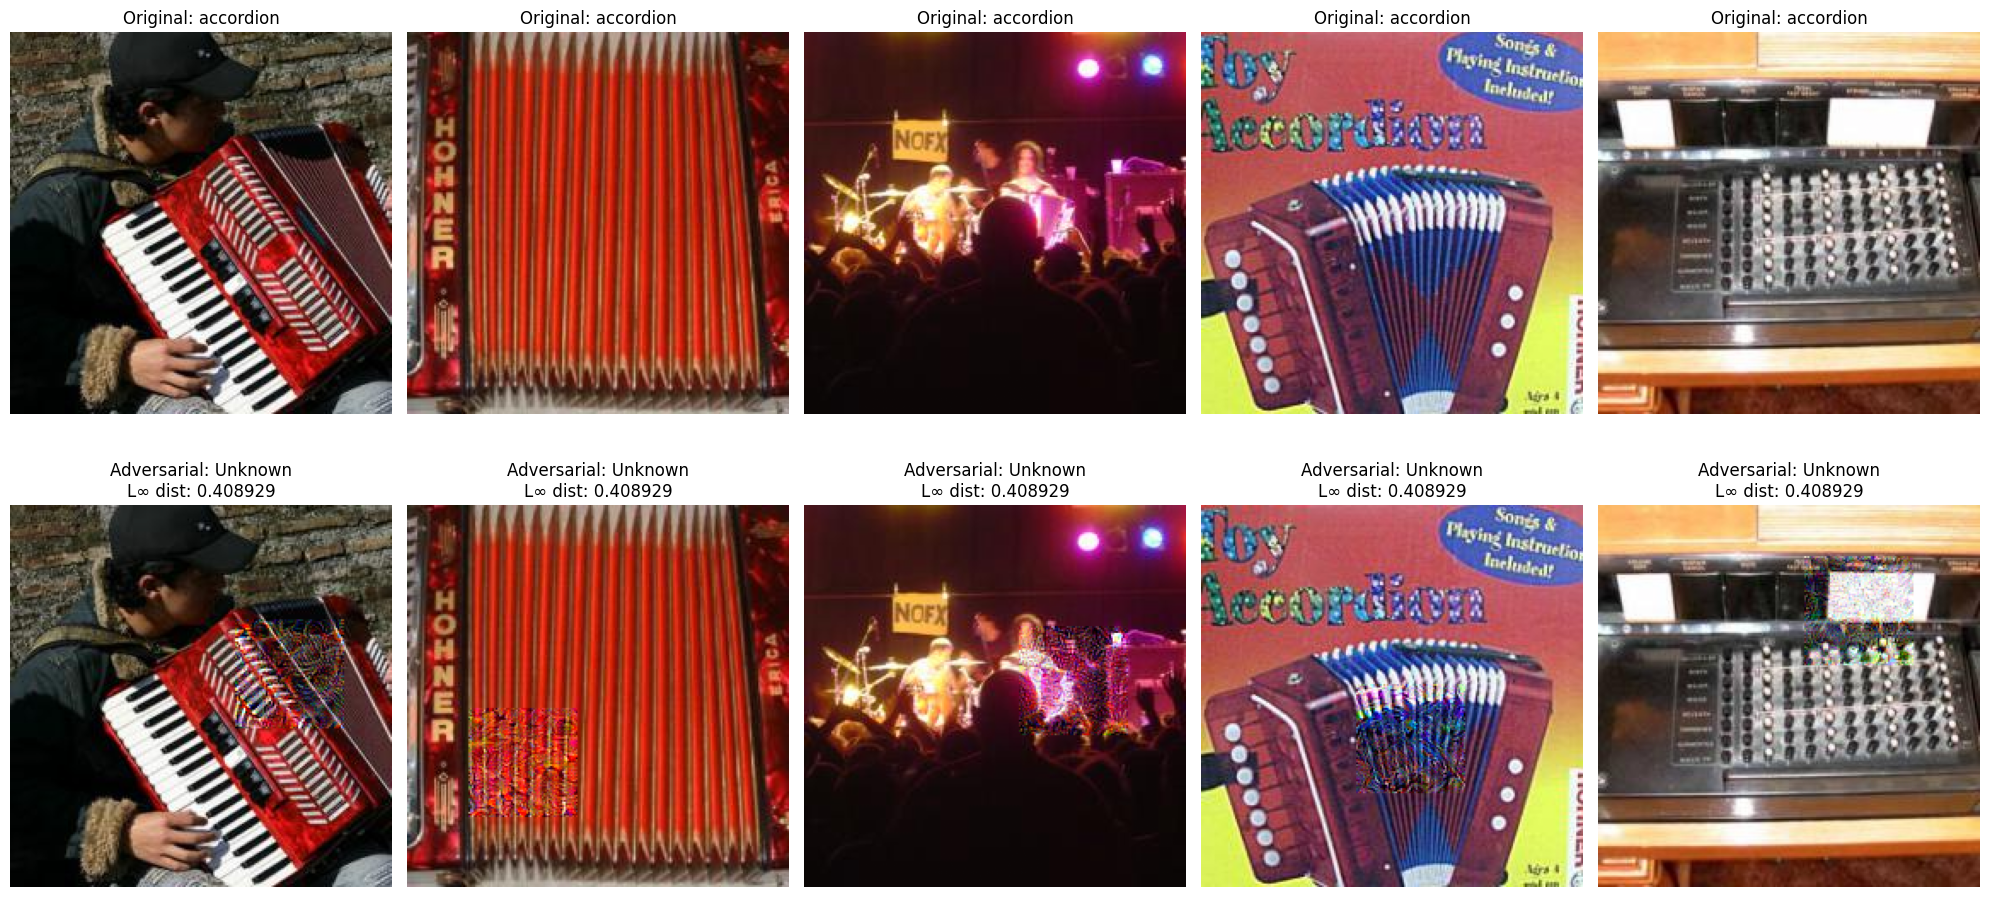

In [56]:
# Visualize successful patch attack examples
if successful_examples:
    plt.figure(figsize=(20, 10))
    for i, (orig_label, orig_img, adv_img, adv_label, linf_dist) in enumerate(successful_examples):
        plt.subplot(2, len(successful_examples), i+1)
        plt.imshow(orig_img.permute(1, 2, 0).numpy())
        plt.title(f"Original: {orig_label}")
        plt.axis('off')

        plt.subplot(2, len(successful_examples), i+len(successful_examples)+1)
        plt.imshow(adv_img.permute(1, 2, 0).numpy())
        plt.title(f"Adversarial: {adv_label}\nL∞ dist: {linf_dist:.6f}")
        plt.axis('off')

    plt.tight_layout()
    plt.savefig('patch_attack_examples.png')
    print("Visualization saved to patch_attack_examples.png")
else:
    print("No successful attack examples found for visualization.")


In [57]:
import torchvision.models as models

# Load a different pretrained ImageNet model
new_model = models.densenet121(weights='IMAGENET1K_V1')
new_model = new_model.to(device)
new_model.eval()


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [58]:
print("\n=== Task 5: Transferability Evaluation with DenseNet-121 ===")

datasets = {
    "Original": dataloader,
    "FGSM": adv_loader,
    "MI-FGSM": adv_loader2,
    "Patch": adv_loader3
}

transfer_results = {}

for name, loader in datasets.items():
    top1, top5 = evaluate_model(new_model, loader, idx_to_imagenet)
    transfer_results[name] = (top1, top5)
    print(f"{name} Set - Top-1 Accuracy: {top1:.4f}, Top-5 Accuracy: {top5:.4f}")



=== Task 5: Transferability Evaluation with DenseNet-121 ===
Original Set - Top-1 Accuracy: 0.7460, Top-5 Accuracy: 0.9360
FGSM Set - Top-1 Accuracy: 0.6000, Top-5 Accuracy: 0.8600
MI-FGSM Set - Top-1 Accuracy: 0.6260, Top-5 Accuracy: 0.8960
Patch Set - Top-1 Accuracy: 0.6180, Top-5 Accuracy: 0.8820


In [59]:
print("\n=== Transferability Results Summary (DenseNet-121) ===")
print(f"{'Dataset':<12} | {'Top-1 Acc':>10} | {'Top-5 Acc':>10}")
print("-" * 38)
for name, (top1, top5) in transfer_results.items():
    print(f"{name:<12} | {top1:>10.4f} | {top5:>10.4f}")



=== Transferability Results Summary (DenseNet-121) ===
Dataset      |  Top-1 Acc |  Top-5 Acc
--------------------------------------
Original     |     0.7460 |     0.9360
FGSM         |     0.6000 |     0.8600
MI-FGSM      |     0.6260 |     0.8960
Patch        |     0.6180 |     0.8820
